In [1]:
import os

from cedtrainscheduler.simulator.config import SimulatorConfig
from cedtrainscheduler.simulator.simulator import Simulator
from cedtrainscheduler.simulator.types import Metrics

base_scheduler = "io_tcp"
"""运行模拟并返回结果"""
current_dir = os.getcwd()  # 使用 os.getcwd() 获取当前工作目录
base_dir = os.path.dirname(current_dir)


class BenchConfig:
    def __init__(
        self,
        cluster_file_name: str,
        fs_file_name: str,
        scheduler_list: list[str],
        task_sample_type: str,
        jobs_count_list: list[int],
    ):
        self.cluster_file_name: str = cluster_file_name
        self.fs_file_name: str = fs_file_name
        self.scheduler_list: list[str] = scheduler_list
        self.task_sample_type: str = task_sample_type
        self.jobs_count_list: list[int] = jobs_count_list


# cluster bench
cluster_config: BenchConfig = BenchConfig(
    cluster_file_name="cluster_config.json",
    fs_file_name="fs_config.json",
    scheduler_list=["fcfs_data", "fcfs", "sjf_data", "sjf", "dtsm", "greedy", "chronus", "allox", "sc_rm", "io_tcp"],
    task_sample_type="light",
    jobs_count_list=[1000, 1300, 1600, 1900, 2200, 2500],
)

micro_cluster_config: BenchConfig = BenchConfig(
    cluster_file_name="micro_cluster_config.json",
    fs_file_name="micro_fs_config.json",
    scheduler_list=["fcfs_data", "fcfs", "sjf_data", "sjf", "dtsm", "greedy", "chronus", "allox", "sc_rm", "io_tcp"],
    task_sample_type="micro",
    jobs_count_list=[10, 20, 30, 40, 50],
)

active_bench_config = micro_cluster_config


def run_simulation(bench_config: BenchConfig) -> dict[int, dict[str, Metrics]]:
    results_dict: dict[int, dict[str, Metrics]] = {}
    for jobs_count in bench_config.jobs_count_list:
        results_dict[jobs_count] = {}
        for scheduler in bench_config.scheduler_list:
            config = SimulatorConfig(
                cluster_config_path=os.path.join(
                    base_dir, "cedtrainscheduler/cases/cluster/" + bench_config.cluster_file_name
                ),
                fs_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/" + bench_config.fs_file_name),
                scheduler_name=scheduler,
                task_config_path=os.path.join(
                    base_dir,
                    f"cedtrainscheduler/cases/task/case_{bench_config.task_sample_type}_{jobs_count}_tasks.csv",
                ),
                output_path=os.path.join(base_dir, "examples/outputs"),
            )

            simulator = Simulator(config)
            results = simulator.simulation()
            results_dict[jobs_count][scheduler] = results
            print(results)
    return results_dict


results_dict = run_simulation(active_bench_config)

Metrics(scheduler_name=<SchedulerType.FCFS_DATA: 1>, task_count=10, total_runtime=3235.0, avg_queue_time=1013.1, avg_running_time=1400.6, avg_execution_time=387.5, cloud_count=0, edge_count=7, terminal_count=3)
Metrics(scheduler_name=<SchedulerType.FCFS: 2>, task_count=10, total_runtime=1601.6, avg_queue_time=488.66, avg_running_time=735.36, avg_execution_time=246.7, cloud_count=1, edge_count=6, terminal_count=3)
Metrics(scheduler_name=<SchedulerType.SJF_DATA: 3>, task_count=10, total_runtime=3260.0, avg_queue_time=910.8, avg_running_time=1220.2, avg_execution_time=309.4, cloud_count=1, edge_count=7, terminal_count=2)
Metrics(scheduler_name=<SchedulerType.SJF: 4>, task_count=10, total_runtime=1730.0, avg_queue_time=497.7, avg_running_time=744.5, avg_execution_time=246.8, cloud_count=2, edge_count=5, terminal_count=3)
Metrics(scheduler_name=<SchedulerType.DTSM: 5>, task_count=10, total_runtime=3016.0, avg_queue_time=822.6600000000001, avg_running_time=1142.46, avg_execution_time=319.8, 

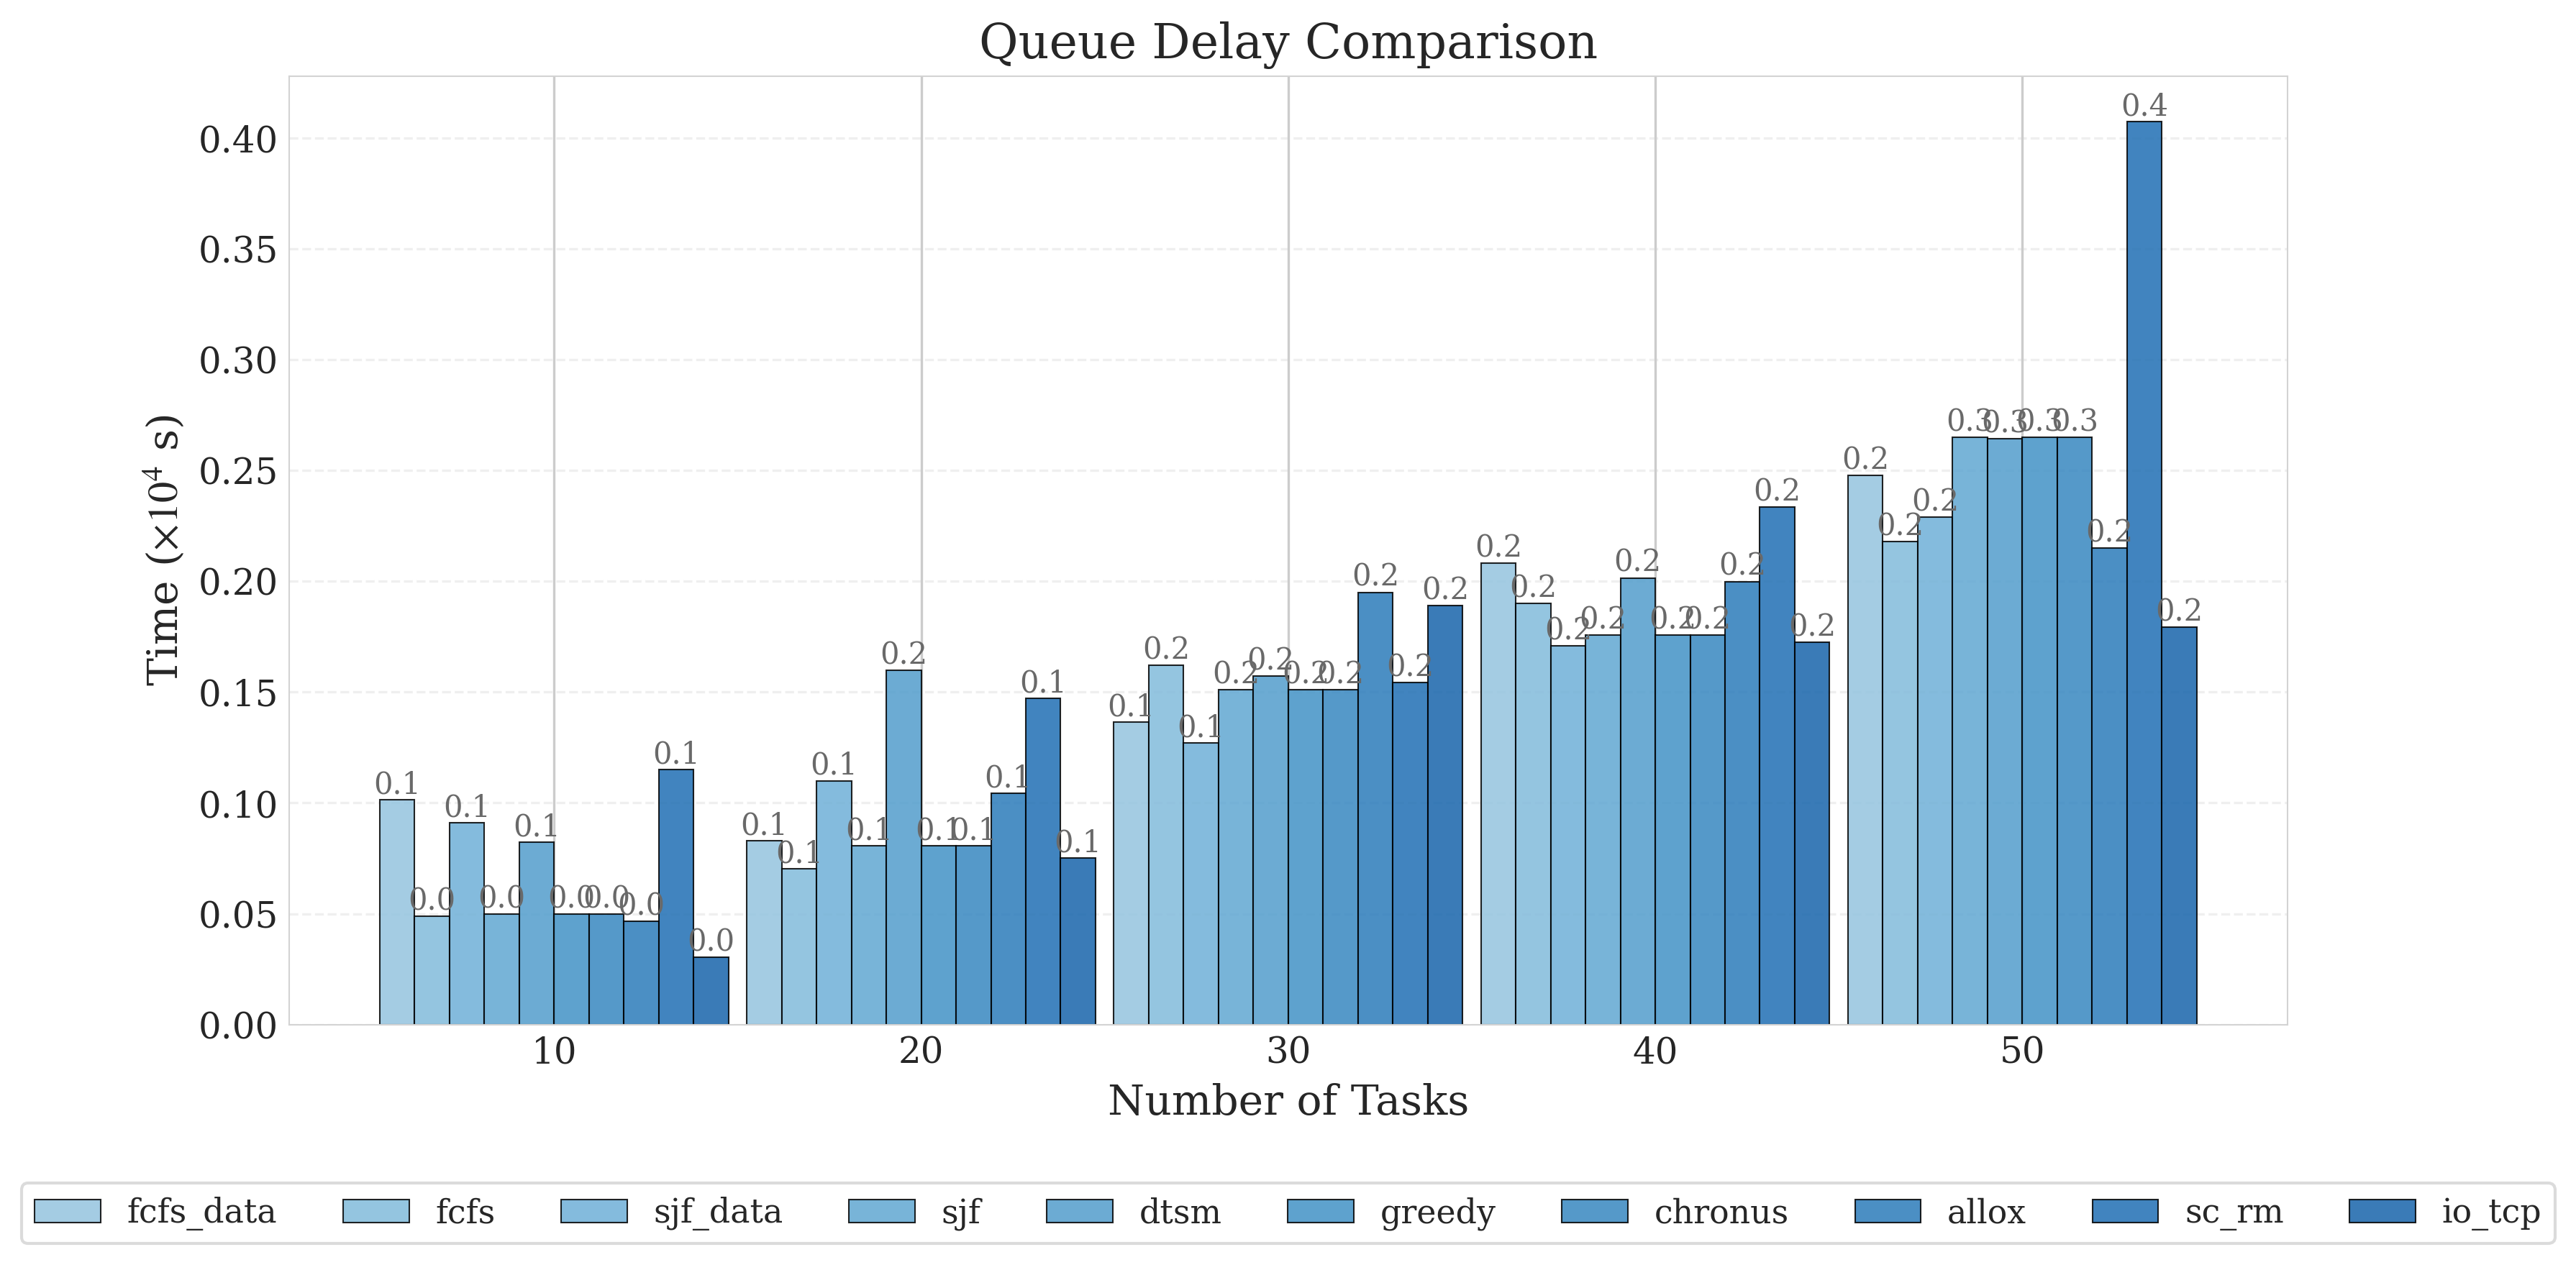

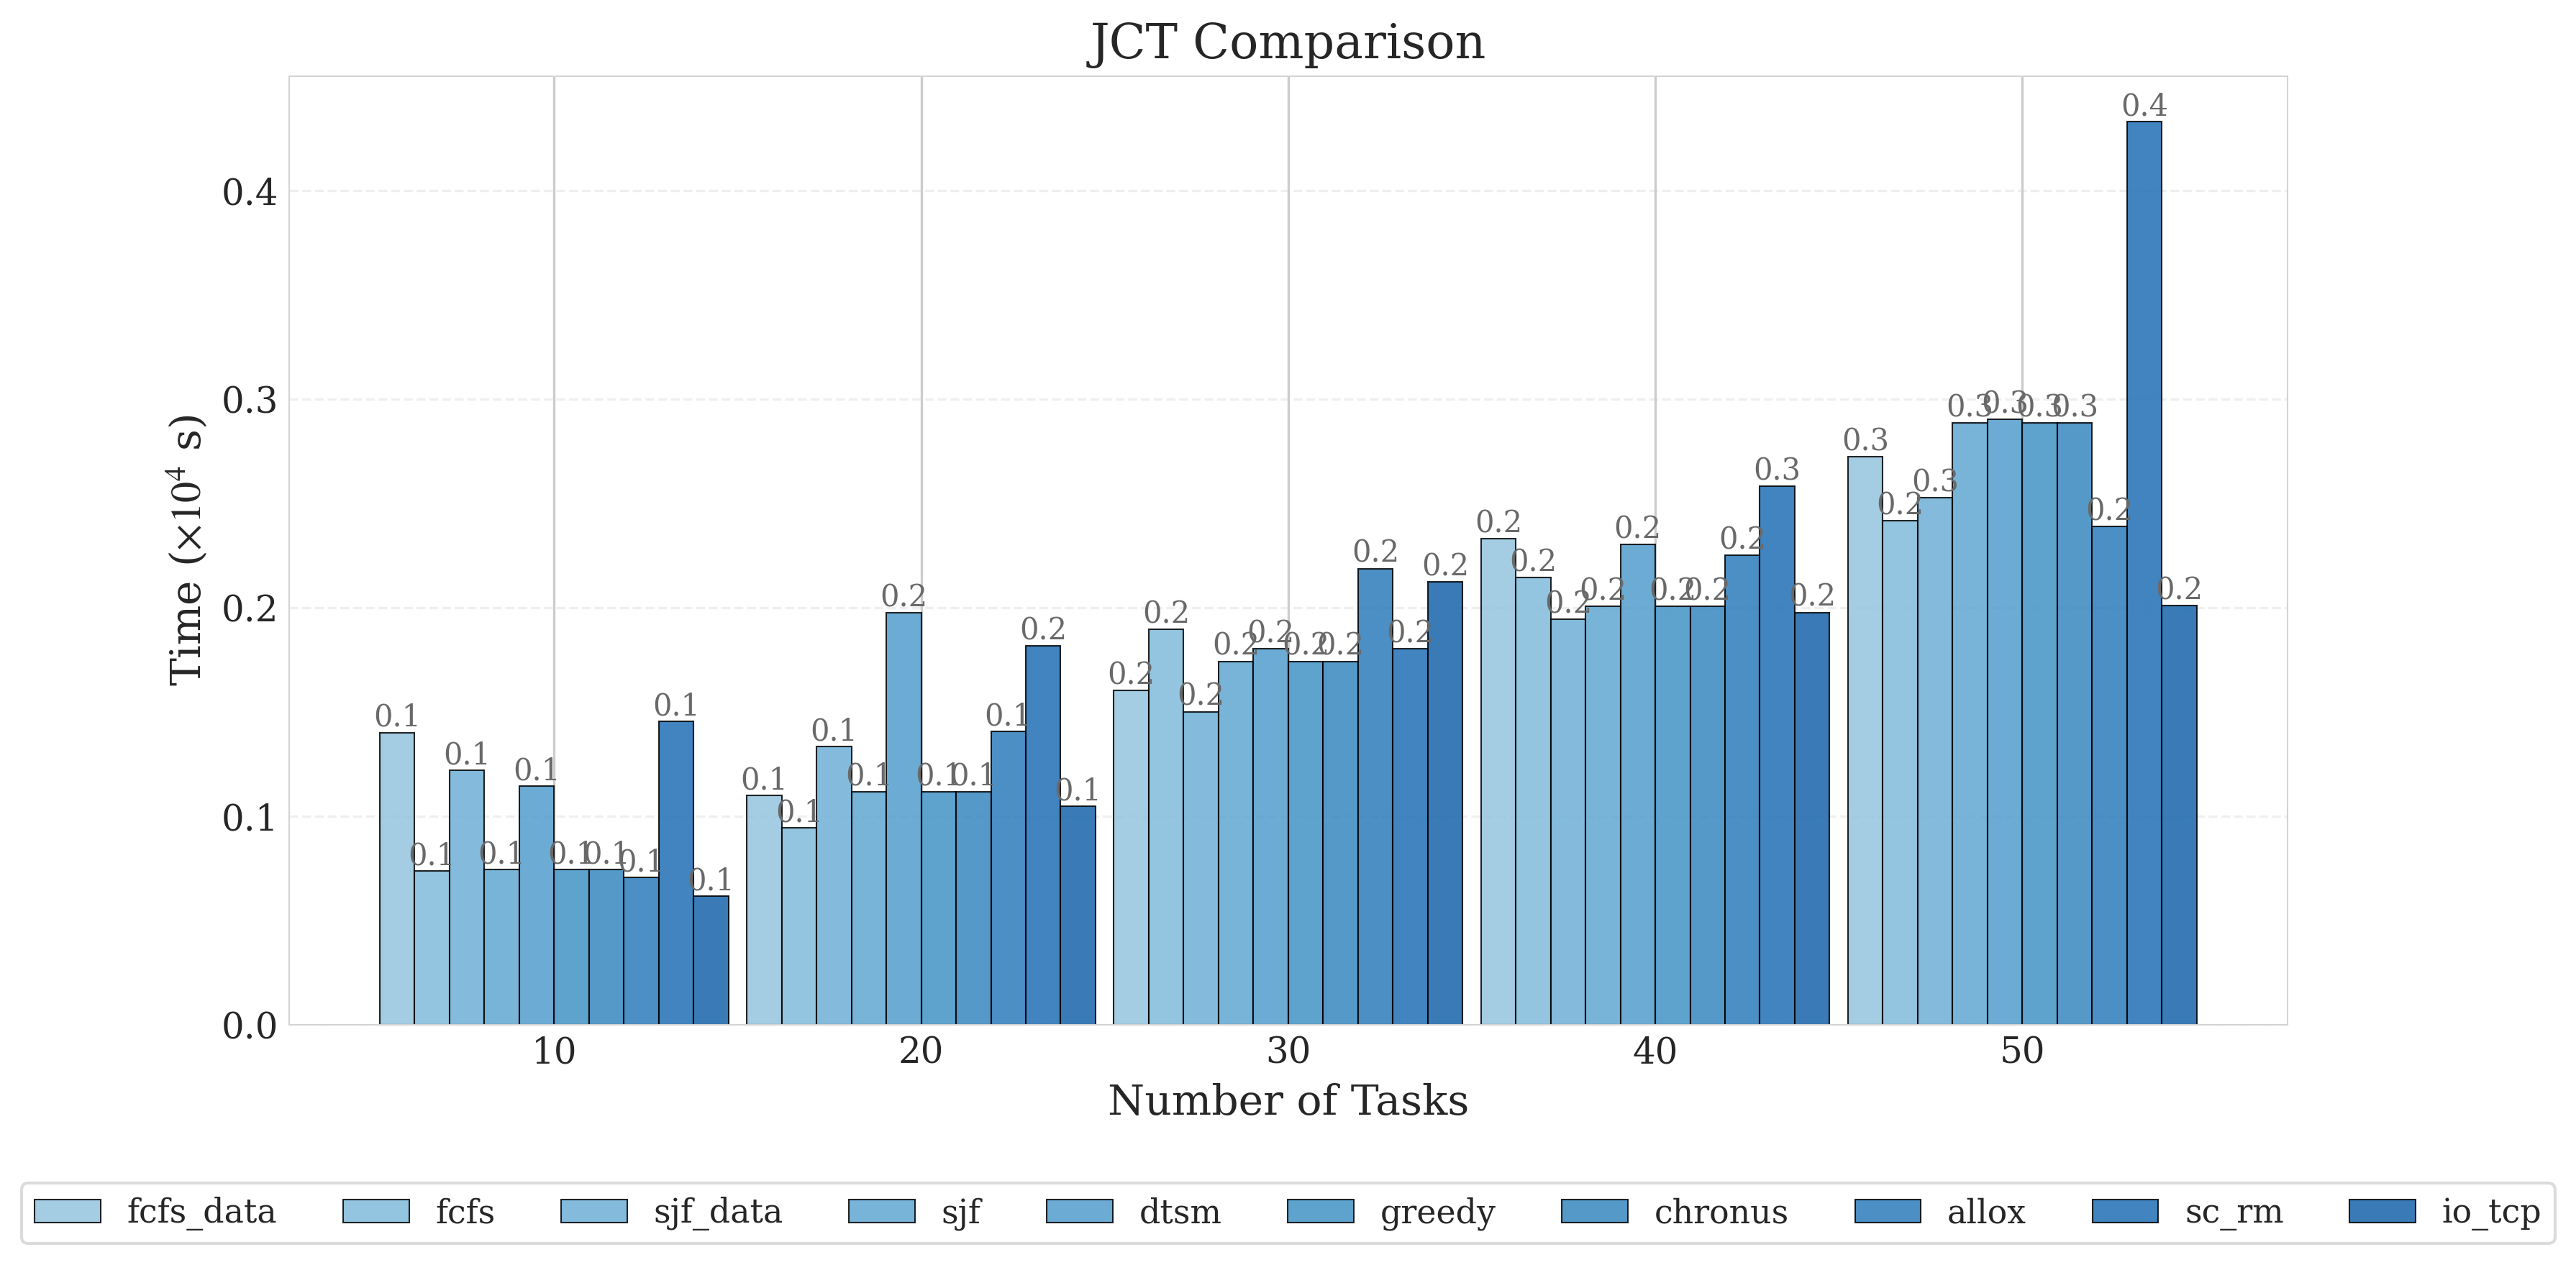

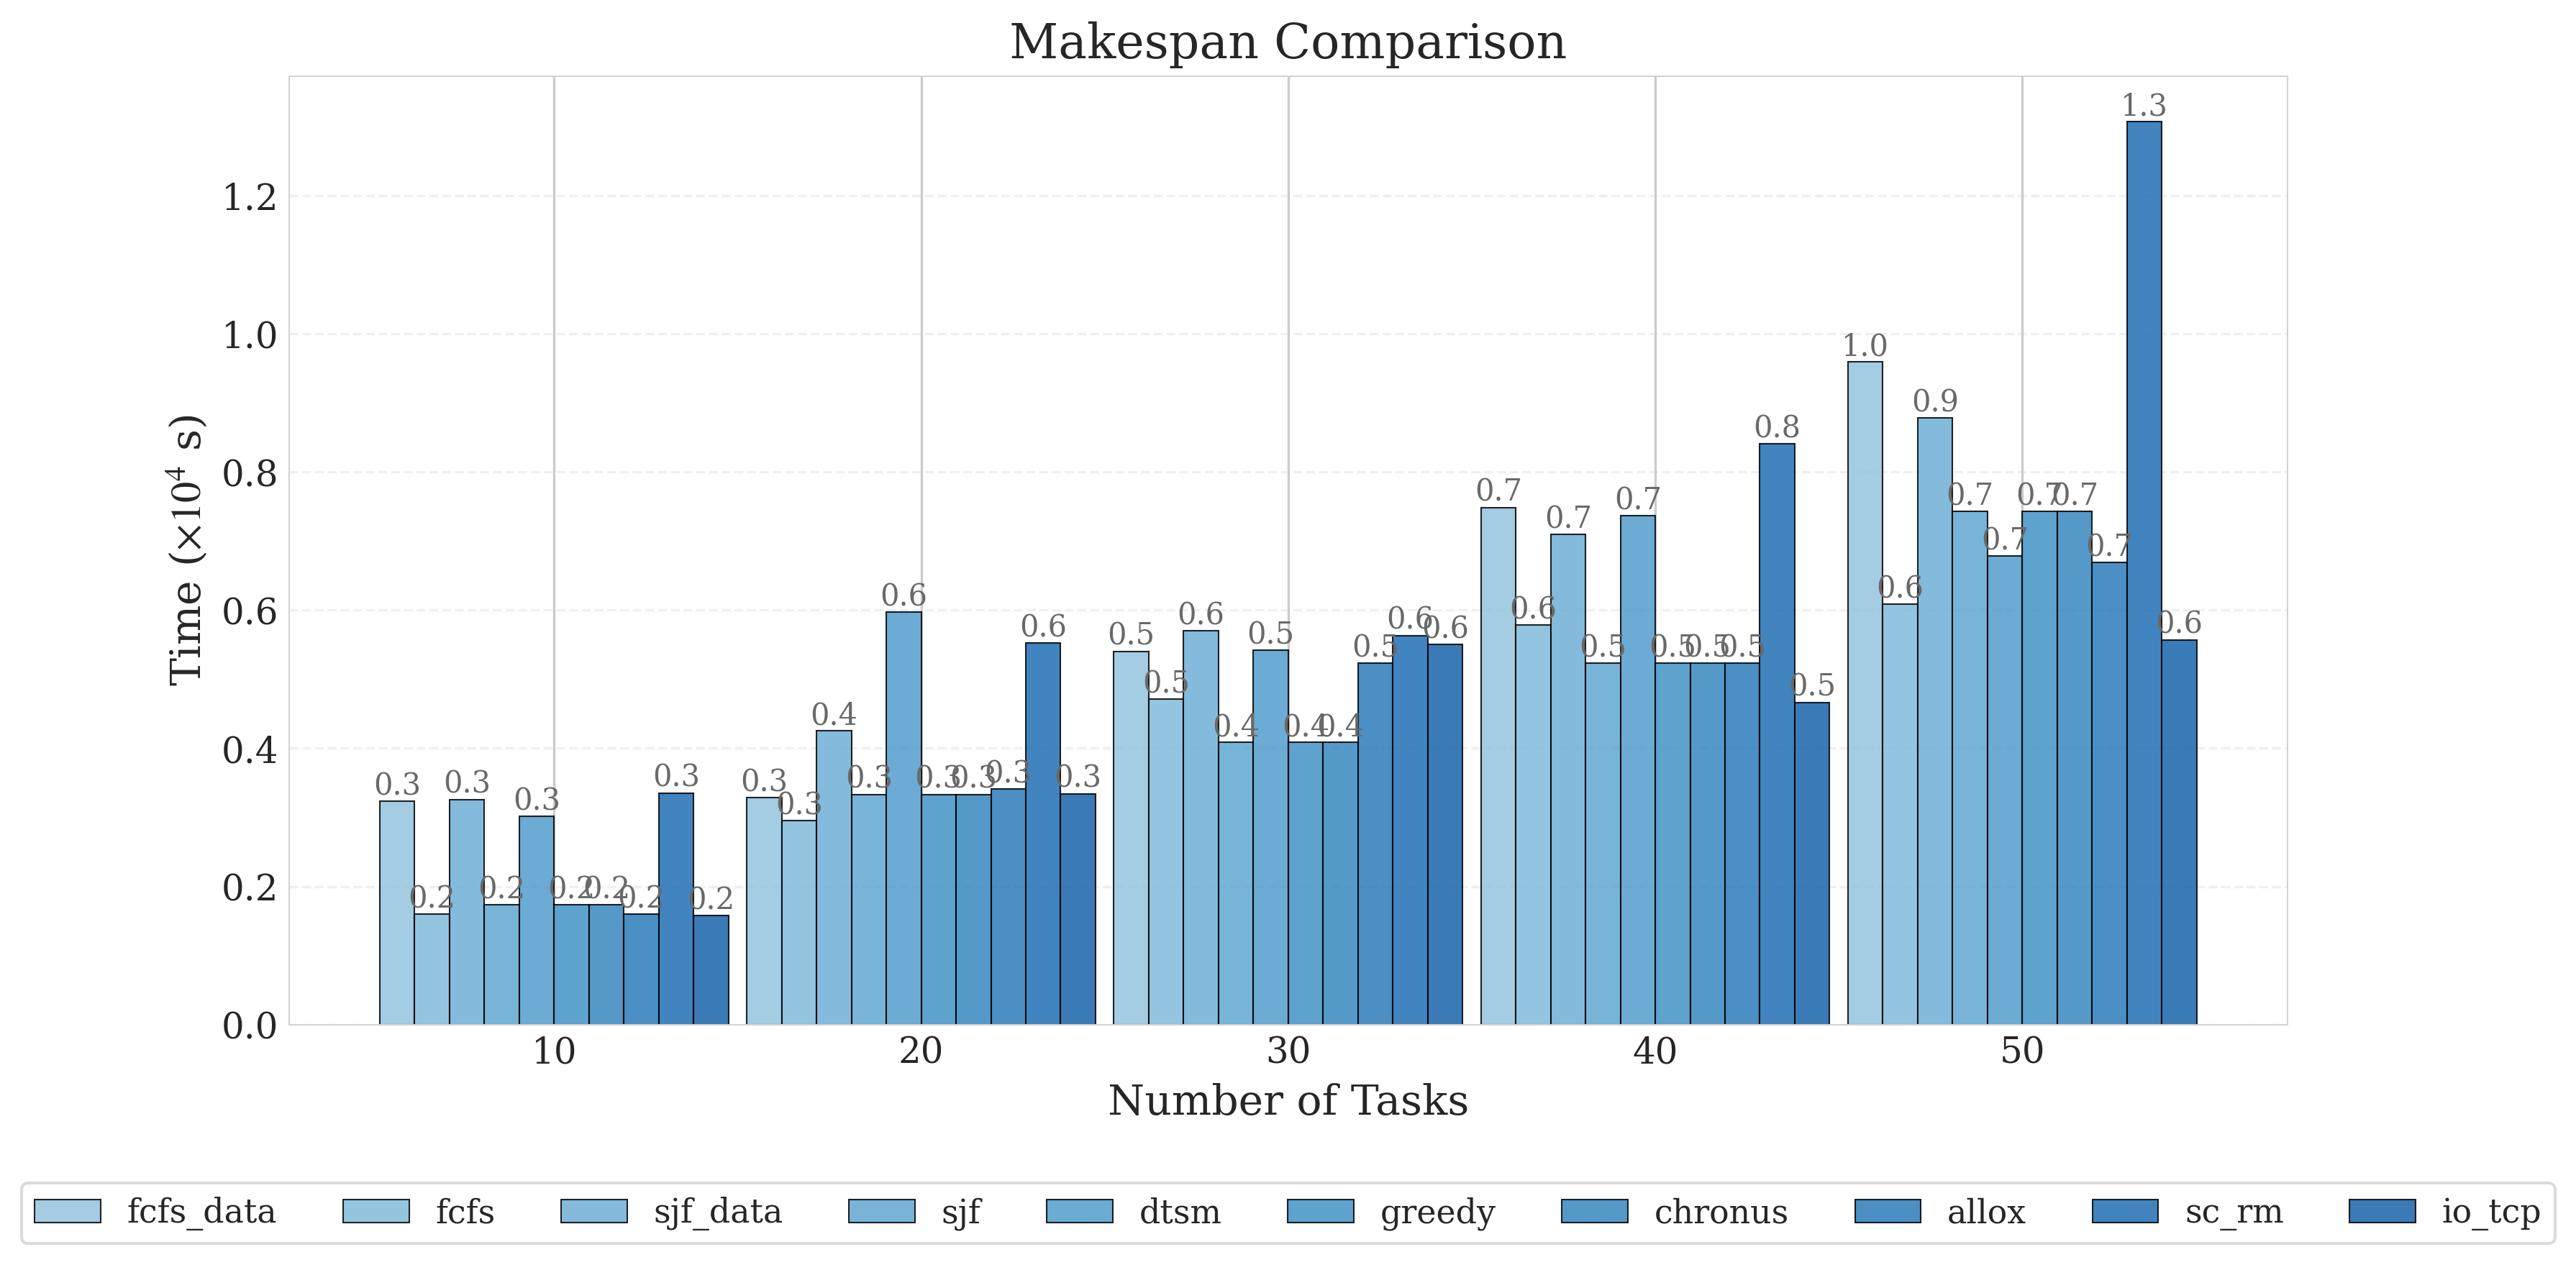

In [2]:
def plot_metrics_comparison(results_dict):
    """绘制不同任务数量下各调度器的性能比较柱状图"""
    import matplotlib.pyplot as plt
    import numpy as np

    # 设置绘图样式
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update(
        {
            "font.family": "serif",
            "font.serif": ["Times New Roman", "DejaVu Serif", "Palatino", "serif"],
            "mathtext.fontset": "stix",
            "axes.labelsize": 14,  # 从11增加到14
            "axes.titlesize": 16,  # 从12增加到16
            "xtick.labelsize": 12,  # 从10增加到12
            "ytick.labelsize": 12,  # 从10增加到12
            "legend.fontsize": 11,  # 从9增加到11
        }
    )

    # 获取调度器列表和任务数量列表
    schedulers = list(results_dict[list(results_dict.keys())[0]].keys())
    jobs_counts = sorted(list(results_dict.keys()))  # 确保任务数量有序

    # 使用不同的颜色方案
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(schedulers)))

    # 设置柱状图的宽度
    width = 0.95 / len(schedulers)  # 根据调度器数量自动调整宽度

    # 指标列表
    metrics = [("avg_queue_time", "Queue Delay"), ("avg_running_time", "JCT"), ("total_runtime", "Makespan")]

    # 为每个指标创建单独的图
    for metric_attr, metric_name in metrics:
        plt.figure(figsize=(12, 6), dpi=300)
        ax = plt.gca()

        # 为每个调度器绘制柱状图
        for scheduler_idx, scheduler in enumerate(schedulers):
            x_positions = np.arange(len(jobs_counts))
            values = [results_dict[jobs_count][scheduler].__getattribute__(metric_attr) for jobs_count in jobs_counts]

            # 计算柱子的位置
            x = x_positions + scheduler_idx * width - (len(schedulers) - 1) * width / 2

            # 绘制柱状图
            bars = ax.bar(
                x,
                [v / 1e4 for v in values],
                width,
                label=scheduler,
                color=colors[scheduler_idx],
                edgecolor="black",
                linewidth=0.5,
                alpha=0.85,
            )

            # 添加数据标签
            for i, v in enumerate(values):
                ax.text(x[i], v / 1e4, f"{v/1e4:.1f}", ha="center", va="bottom", fontsize=10, color="dimgray")

        # 设置图表样式
        ax.set_title(f"{metric_name} Comparison")
        ax.set_xlabel("Number of Tasks")
        ax.set_ylabel("Time ($\\times 10^4$ s)")

        # 设置x轴刻度
        ax.set_xticks(x_positions)
        ax.set_xticklabels(jobs_counts)

        # 设置网格线
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

        # 美化边框
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color("lightgray")

        # 添加图例
        plt.legend(
            bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=len(schedulers), frameon=True, edgecolor="lightgray"
        )

        # 调整布局
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)

        plt.show()
        plt.close()


# 使用示例
plot_metrics_comparison(results_dict)

In [3]:
def calculate_metrics_reduction(results_dict, compare_scheduler):
    """计算CED策略相对于其他调度器的各项指标降低百分比

    Args:
        results_dict: 包含不同任务数量下各调度器结果的字典

    Returns:
        dict: 每个任务数量下各指标的降低百分比
    """
    metrics_reduction = {}

    # 遍历每个任务数量
    for job_count in results_dict.keys():
        metrics_reduction[job_count] = {"queue_delay": {}, "jct": {}, "makespan": {}}

        results = results_dict[job_count]

        # 获取CED的基准值
        ced_queue_delay = results[compare_scheduler].avg_queue_time
        ced_jct = results[compare_scheduler].avg_running_time
        ced_makespan = results[compare_scheduler].total_runtime

        # 计算相对于其他调度器的降低百分比
        for scheduler in results.keys():
            if scheduler == compare_scheduler:
                continue

            # 计算队列等待时间降低百分比
            queue_delay = results[scheduler].avg_queue_time
            queue_reduction = ((queue_delay - ced_queue_delay) / queue_delay) * 100
            metrics_reduction[job_count]["queue_delay"][scheduler] = queue_reduction

            # 计算JCT降低百分比
            jct = results[scheduler].avg_running_time
            jct_reduction = ((jct - ced_jct) / jct) * 100
            metrics_reduction[job_count]["jct"][scheduler] = jct_reduction

            # 计算Makespan降低百分比
            makespan = results[scheduler].total_runtime
            makespan_reduction = ((makespan - ced_makespan) / makespan) * 100
            metrics_reduction[job_count]["makespan"][scheduler] = makespan_reduction

    return metrics_reduction


def print_metrics_reduction(metrics_reduction):
    """打印各项指标的降低百分比"""
    metrics_names = {"queue_delay": "Queue Delay", "jct": "JCT", "makespan": "Makespan"}

    for job_count in metrics_reduction.keys():
        print(f"\n任务数量: {job_count}")
        for metric_key, metric_name in metrics_names.items():
            print(f"\nCED的{metric_name}降低百分比相对于其他调度器:")
            for scheduler, reduction in metrics_reduction[job_count][metric_key].items():
                print(f"{scheduler}: 降低了 {reduction:.2f}%")


# 使用示例
metrics_reduction = calculate_metrics_reduction(results_dict, base_scheduler)
print_metrics_reduction(metrics_reduction)


任务数量: 10

CED的Queue Delay降低百分比相对于其他调度器:
fcfs_data: 降低了 70.09%
fcfs: 降低了 38.00%
sjf_data: 降低了 66.73%
sjf: 降低了 39.12%
dtsm: 降低了 63.17%
greedy: 降低了 39.12%
chronus: 降低了 39.12%
allox: 降低了 35.12%
sc_rm: 降低了 73.66%

CED的JCT降低百分比相对于其他调度器:
fcfs_data: 降低了 55.93%
fcfs: 降低了 16.06%
sjf_data: 降低了 49.41%
sjf: 降低了 17.09%
dtsm: 降低了 45.97%
greedy: 降低了 17.09%
chronus: 降低了 17.09%
allox: 降低了 12.64%
sc_rm: 降低了 57.54%

CED的Makespan降低百分比相对于其他调度器:
fcfs_data: 降低了 51.31%
fcfs: 降低了 1.66%
sjf_data: 降低了 51.69%
sjf: 降低了 8.96%
dtsm: 降低了 47.78%
greedy: 降低了 8.96%
chronus: 降低了 8.96%
allox: 降低了 1.78%
sc_rm: 降低了 53.04%

任务数量: 20

CED的Queue Delay降低百分比相对于其他调度器:
fcfs_data: 降低了 9.23%
fcfs: 降低了 -6.93%
sjf_data: 降低了 31.66%
sjf: 降低了 6.93%
dtsm: 降低了 52.95%
greedy: 降低了 6.93%
chronus: 降低了 6.93%
allox: 降低了 28.03%
sc_rm: 降低了 48.95%

CED的JCT降低百分比相对于其他调度器:
fcfs_data: 降低了 4.85%
fcfs: 降低了 -10.84%
sjf_data: 降低了 21.65%
sjf: 降低了 6.44%
dtsm: 降低了 47.03%
greedy: 降低了 6.44%
chronus: 降低了 6.44%
allox: 降低了 25.59%
sc_rm: 降低了 42.41%

CED的Makespan降低百